In [3]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

from mymodel import DeepONet

ImportError: cannot import name 'NN1' from 'mymodel' (/home/lmh/Desktop/DeepONet/thermal_infer/mymodel/__init__.py)

In [1]:
DATADIR = "../dataset/nov_dataset/"

d = np.load(f"{DATADIR}L2_bc_train.npz", allow_pickle=True)
# d = np.load("../nov_dataset/L2_bc_train_mod.npz", allow_pickle=True)
X_train = (d["X_train0"].astype(np.float32), d["X_train1"].astype(np.float32))
y_train = d["y_train"].astype(np.float32)
print(d['X_train0'].shape)
print(d['X_train1'].shape)
print(d['y_train'].shape)

# d = np.load("../csvdata/antiderivative_unaligned_test/antiderivative_unaligned_test.npz", allow_pickle=True)
d = np.load(f"{DATADIR}L2_bc_test.npz", allow_pickle=True)
# d = np.load("../nov_dataset/L2_bc_test_mod.npz", allow_pickle=True)
X_test = (d["X_test0"].astype(np.float32), d["X_test1"].astype(np.float32))
y_test = d["y_test"].astype(np.float32)
print(d['X_test0'].shape)
print(d['X_test1'].shape)
print(d['y_test'].shape)

NameError: name 'np' is not defined

In [19]:
# The couple of the first two elements are the input, and the third element is the output. This dataset can be used with the network DeepONet for operator learning.
data = dde.data.Triple(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# Choose a network
m = 81
dim_x = 3

net = DeepONet(
    [m, 40, 40],
    [dim_x, 40, 40],
    "relu",
    "Glorot normal",
)

In [ ]:
# Define a Model
model = dde.Model(data, net)
print(model)
# Compile and Train
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=20000)

# save model
model.save("deeponet")

L2 relative error: 1.0428857
Saving loss history to /home/lmh/Desktop/DeepONet/real_thermal/loss.dat ...
Error: The network has multiple inputs, and saving such result han't been implemented.
Error: The network has multiple inputs, and plotting such result han't been implemented.


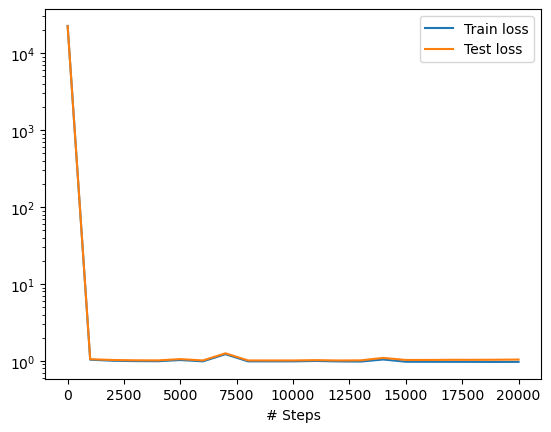

In [23]:
# Plot the loss trajectory
y_pred = model.predict(X_test)

# print results
print("L2 relative error:", dde.metrics.mean_squared_error(y_test, y_pred))
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# save y_test and y_pred to csv
np.savetxt("y_test.csv", y_test, delimiter=",")
np.savetxt("y_pred.csv", y_pred, delimiter=",")

# save d["X_test1"]
np.savetxt("X_test1.csv", d["X_test1"], delimiter=",")

# plot return sensor tempreture

In [24]:
# [time * temperture] -> [temperture, time] for sensors
y_test_plot = y_test.reshape(-1, 36)
y_pred_plot = y_pred.reshape(-1, 36)
print(y_test_plot.shape)
print(y_pred_plot.shape)

(170, 36)
(170, 36)


In [26]:
# Read joblib file
from joblib import load

scaler = load(f'{DATADIR}/return_temp_scaler.joblib')
ori_y_test = scaler.inverse_transform(y_test_plot).T
ori_y_pred = scaler.inverse_transform(y_pred_plot).T

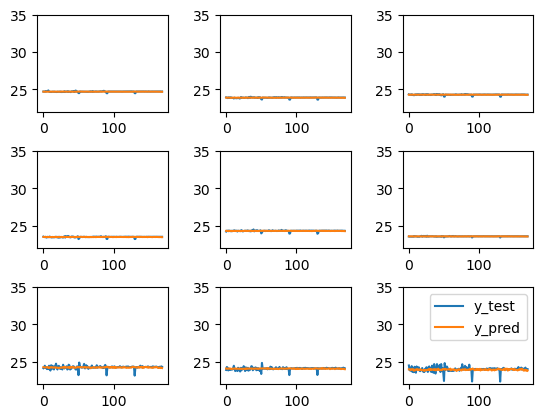

In [43]:
sensors = range(27,36)

nrows = int(len(sensors)/3)
ncols = 3

# subplot
for i in range(len(sensors)):
  sensor = sensors[i]
  plt.subplot(nrows, ncols, i+1)
  plt.ylim(22, 35)
  plt.plot(ori_y_test[sensor], label="y_test")
  plt.plot(ori_y_pred[sensor], label="y_pred")
  plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.legend()

# plt.plot(ori_y_test[sensor], label="y_test")
# plt.plot(ori_y_pred[sensor], label="y_pred")
# plt.subplots_adjust(wspace=0.4, hspace=0.4)
# plt.legend()
# plt.show()

# SUPPLY TEMP MODIFICATION

In [68]:
# modification
from joblib import load

# generate normed data (temp -> temp+2)
# read supply temp data
supply_temp_data = d["X_test0"][:,1:17]
print(supply_temp_data.shape)
print(supply_temp_data[0])
# inverse norm
scaler = load(f'{DATADIR}supply_temp_scaler.joblib')
supply_temp_data = scaler.inverse_transform(supply_temp_data)
print(supply_temp_data[0])

# mod and norm - low
supply_temp_data_mod_low = supply_temp_data - 1
print(supply_temp_data_mod_low[0])
supply_temp_data_mod_low = scaler.transform(supply_temp_data_mod_low)
print(supply_temp_data_mod_low[0])

# mod and norm - high
supply_temp_data_mod_high = supply_temp_data + 1
print(supply_temp_data_mod_high[0])
supply_temp_data_mod_high = scaler.transform(supply_temp_data_mod_high)
print(supply_temp_data_mod_high[0])

# new X_test - low
X_test0_mod_low = np.concatenate((supply_temp_data_mod_low, d["X_test0"][:,16:]), axis=1)
X_test_mod_low = (X_test0_mod_low, d["X_test1"].astype(np.float32))

# new X_test - high
X_test0_mod_high = np.concatenate((supply_temp_data_mod_high, d["X_test0"][:,16:]), axis=1)
X_test_mod_high = (X_test0_mod_high, d["X_test1"].astype(np.float32))

(6120, 16)
[0.17256978750000007 0.17248847416666666 0.17248815500000006
 0.1724533066666667 0.17230287166666672 0.17229882333333327
 0.17240170166666666 0.17133380416666663 0.17047078833333332
 0.1703856633333333 0.17035491000000005 0.17032004833333328
 0.1704465333333333 0.1703347433333334 0.17046864249999993
 0.7675046381964195]
[22.59271643 23.02181085 23.00695322 23.51375442 22.5115081  22.51433672
 22.51191114 25.24523353 23.18541599 22.53307999 23.08627252 23.01696053
 23.03980433 23.13656337 23.14718773 23.54951465]
[21.59271643 22.02181085 22.00695322 22.51375442 21.5115081  21.51433672
 21.51191114 24.24523353 22.18541599 21.53307999 22.08627252 22.01696053
 22.03980433 22.13656337 22.14718773 22.54951465]
[ -5.37287266  -8.82442639 -24.63445876  -8.92186536 -19.72207753
 -11.29047513 -13.13758773 -18.61028081  -3.04684356  -6.41895518
  -2.28933727  -9.59201939  -4.40715634  -2.19152426  -2.03604013
  -0.72986026]
[23.59271643 24.02181085 24.00695322 24.51375442 23.5115081  2

# FLOW RATE MOD

In [74]:
# modification
from joblib import load

# generate normed data (temp -> temp+2)
# read supply temp data
flow_rate_data = d["X_test0"][:,:16]
print(flow_rate_data.shape)
# inverse norm
# scaler = load('../nov_dataset/flow_rate_scaler.joblib')
# flow_rate_data = scaler.inverse_transform(flow_rate_data)

# inverse norm
print(flow_rate_data[0])
flow_rate_data = flow_rate_data * 12 + 8
print(flow_rate_data[0])
# mod and norm - low
flow_rate_data_mod_low = flow_rate_data - 2
# flow_rate_data_mod_low = scaler.transform(flow_rate_data_mod_low)

# mod and norm - high
flow_rate_data_mod_high = flow_rate_data + 2
# flow_rate_data_mod_high = scaler.transform(flow_rate_data_mod_high)

# new X_test - low
X_test0_mod_low = np.concatenate((flow_rate_data_mod_low, d["X_test0"][:,16:]), axis=1)
X_test_mod_low = (X_test0_mod_low, d["X_test1"].astype(np.float32))

# new X_test - high
X_test0_mod_high = np.concatenate((flow_rate_data_mod_high, d["X_test0"][:,16:]), axis=1)
X_test_mod_high = (X_test0_mod_high, d["X_test1"].astype(np.float32))

(6120, 16)
[0.17262004833333341 0.17256978750000007 0.17248847416666666
 0.17248815500000006 0.1724533066666667 0.17230287166666672
 0.17229882333333327 0.17240170166666666 0.17133380416666663
 0.17047078833333332 0.1703856633333333 0.17035491000000005
 0.17032004833333328 0.1704465333333333 0.1703347433333334
 0.17046864249999993]
[10.07144058 10.07083745 10.06986169 10.06985786 10.06943968 10.06763446
 10.06758588 10.06882042 10.05600565 10.04564946 10.04462796 10.04425892
 10.04384058 10.0453584 10.04401692 10.04562371]


# TEST

In [75]:
# Plot the loss trajectory
y_pred_mod_low = model.predict(X_test_mod_low)
y_pred_mod_high = model.predict(X_test_mod_high)
y_pred_ori = model.predict(X_test)

# [time * temperture] -> [temperture, time] for sensors
y_pred_mod_low = y_pred_mod_low.reshape(-1, 36)
y_pred_mod_high = y_pred_mod_high.reshape(-1, 36)
y_pred_ori = y_pred_ori.reshape(-1, 36)
print(y_pred_mod_low.shape)
print(y_pred_mod_high.shape)
print(y_pred_ori.shape)

(170, 36)
(170, 36)
(170, 36)


In [76]:
from joblib import load

# load mod data
scaler = load(f'{DATADIR}return_temp_scaler.joblib')
y_pred_mod_low = scaler.inverse_transform(y_pred_mod_low).T
y_pred_mod_high = scaler.inverse_transform(y_pred_mod_high).T
y_pred_ori = scaler.inverse_transform(y_pred_ori).T

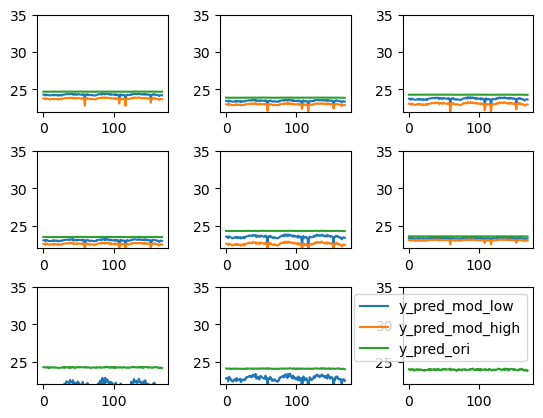

In [81]:
# sensor = 0
sensors = range(27,36)

nrows = int(len(sensors)/3)
ncols = 3

# subplot
for i in range(len(sensors)):
  sensor = sensors[i]
  plt.subplot(nrows, ncols, i+1)
  plt.ylim(22, 35)
  plt.plot(y_pred_mod_low[sensor], label="y_pred_mod_low")
  plt.plot(y_pred_mod_high[sensor], label="y_pred_mod_high")
  plt.plot(y_pred_ori[sensor], label="y_pred_ori")
  plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.legend()

# # Plot the results
# plt.plot(y_pred_mod_low[sensor], label="y_pred_mod_low")
# plt.plot(y_pred_mod_high[sensor], label="y_pred_mod_high")
# plt.plot(y_pred_ori[sensor], label="y_pred_ori")
# plt.legend()
# plt.show()